# Characters Classification with Neural Networks

In this notebook we are going to use the Neural Networks for image classification. We are going to use the same dataset of the lab on SVM: Kuzushiji-MNIST or K-MNIST for short (https://github.com/rois-codh/kmnist) a dataset of traditional japanese handwritten kana.

The dataset labels are the following:

| Label | Hiragana Character | Romanji (Pronunciation) |
| :-: | :-: | :-: |
|   0   | お | o |
| 1 | き | ki |
| 2 | す | su |
| 3 | つ | tsu |
| 4 | な | na |
| 5 | は | ha |
| 6 | ま | ma |
| 7 | や | ya |
| 8 | れ | re |
| 9 | を | wo |

In [1]:
%matplotlib inline  

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import display, HTML

import sklearn
print ('scikit-learn version: ', sklearn.__version__)
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

scikit-learn version:  0.24.1


In [2]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np
    labels_path = os.path.join(path, 'K%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, 'K%s-images-idx3-ubyte.gz' % kind)
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 784)
    return images, labels

# TODO 
Set as seed for the random generator your Student ID (you can use your "numero di matricola"). Try to change the seed to see the impact of the randomization.

In [3]:
ID = 1187687
np.random.seed(ID)

In [4]:
#load the MNIST dataset and let's normalize the features so that each value is in [0,1]
X, y = load_mnist("data")
print("Number of samples in the K-MNIST dataset:", X.shape[0])
# rescale the data
X = X / 255.0

Number of samples in the K-MNIST dataset: 60000


Now split into training and test. We start with a small training set of 600 samples to reduce computation time while 4000 samples will be used for testing. Make sure that each label is present at least 10 times in train and test set frequencies.

In [5]:
#random permute the data and split into training and test taking the first 600
#data samples as training and 4000 as test set
permutation = np.random.permutation(X.shape[0])

X = X[permutation]
y = y[permutation]

m_training = 600
m_test = 4000

X_train, X_test = X[:m_training], X[m_training:m_training+m_test]
y_train, y_test = y[:m_training], y[m_training:m_training+m_test]

labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

labelsT, freqsT = np.unique(y_test, return_counts=True)
print("Labels in test set: ", labels)
print("Frequencies in test set: ", freqs)


Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [52 53 49 63 55 58 57 81 64 68]
Labels in test set:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in test set:  [52 53 49 63 55 58 57 81 64 68]


In [6]:
#function for plotting a image and printing the corresponding label
def plot_input(X_matrix, labels, index):
    print("INPUT:")
    plt.imshow(
        X_matrix[index].reshape(28,28),
        cmap          = plt.cm.gray_r,
        interpolation = "nearest"
    )
    plt.show()
    print("LABEL: %i"%labels[index])
    return

INPUT:


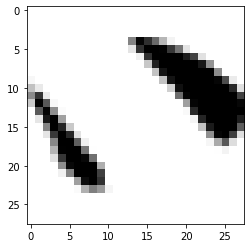

LABEL: 5
INPUT:


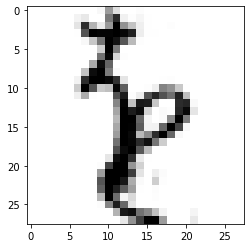

LABEL: 9
INPUT:


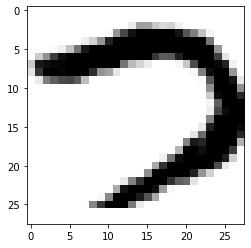

LABEL: 3


In [7]:
#let's try the plotting function
plot_input(X_train,y_train,10)
plot_input(X_test,y_test,100)
plot_input(X_test,y_test,1000)

### TO DO 1

Now use a feed-forward Neural Network for prediction. Use the multi-layer perceptron classifier, with the following parameters: max_iter=100, alpha=1e-4, solver='sgd', tol=1e-4, learning_rate_init=.1, random_state=ID (this last parameter ensures the run is the same even if you run it more than once). The alpha parameter is the regularization term.

Then, using the default activation function, pick four or five architectures to consider, with different numbers of hidden layers and different sizes. It is not necessary to create huge neural networks, you can limit to 3 layers and, for each layer, its maximum size can be of 50. Evaluate the architectures you chose using GridSearchCV with cv=5.

You can reduce the number of iterations if the running time is too long on your computer.


In [8]:
parameters = {'hidden_layer_sizes': [(10,), (20,), (40,), (20,20,), (40,20,10) ]}

mlp = MLPClassifier(max_iter=100, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=ID,
                    learning_rate_init=.1)


grd = GridSearchCV( estimator = mlp, param_grid=parameters, cv = 5, n_jobs = 3, return_train_score = True) 
grd.fit(X_train, y_train)

print(f"Check 5 fold validation: {grd.n_splits_ == 5}\n")

print ('RESULTS FOR NN\n')

results = pd.DataFrame(grd.cv_results_)
print (f'{display(HTML(results.to_html()))}\n')

print(f"Best parameters set found: {grd.best_params_}\n")

print(f"Score with best parameters: {grd.best_score_}\n")

print("All scores on the grid:\n")
scores_all=pd.DataFrame(results[['param_hidden_layer_sizes', 'mean_test_score']])
print (f'{display(HTML(scores_all.to_html()))}')

Check 5 fold validation: True

RESULTS FOR NN



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.830235,0.252416,0.001631,0.000430,"(10,)","{'hidden_layer_sizes': (10,)}",0.691667,0.708333,0.716667,0.716667,0.708333,0.708333,0.009129,4,1.0,1.0,1.0,1.00000,1.0,1.00000,0.0000
1,0.809133,0.141575,0.001835,0.000347,"(20,)","{'hidden_layer_sizes': (20,)}",0.708333,0.725000,0.766667,0.816667,0.741667,0.751667,0.037786,2,1.0,1.0,1.0,1.00000,1.0,1.00000,0.0000
2,0.981207,0.196207,0.002137,0.000447,"(40,)","{'hidden_layer_sizes': (40,)}",0.741667,0.758333,0.800000,0.800000,0.791667,0.778333,0.023921,1,1.0,1.0,1.0,1.00000,1.0,1.00000,0.0000
3,0.645922,0.147304,0.001783,0.000473,"(20, 20)","{'hidden_layer_sizes': (20, 20)}",0.716667,0.733333,0.733333,0.725000,0.725000,0.726667,0.006236,3,1.0,1.0,1.0,1.00000,1.0,1.00000,0.0000
4,0.790136,0.336994,0.001602,0.000446,"(40, 20, 10)","{'hidden_layer_sizes': (40, 20, 10)}",0.716667,0.666667,0.650000,0.508333,0.716667,0.651667,0.076449,5,1.0,1.0,1.0,0.58125,1.0,0.91625,0.1675


None

Best parameters set found: {'hidden_layer_sizes': (40,)}

Score with best parameters: 0.7783333333333332

All scores on the grid:



,param_hidden_layer_sizes,mean_test_score
0,"(10,)",0.708333
1,"(20,)",0.751667
2,"(40,)",0.778333
3,"(20, 20)",0.726667
4,"(40, 20, 10)",0.651667


None


### TO DO 2

Now try also different batch sizes, while keeping the best NN architecture you have found above. Remember that the batch size was previously set to the default value, i.e., min(200, n_samples). 
Recall that a batch size of 1 corresponds to baseline SGD, while using all the 480 training samples (there are 600 samples but in cross validation with 5 folders we use 1/5 of them for validation at each round) corresponds to standard GD and using a different mini-batch size lies in the middle between the two extreme cases.

In [9]:
# need to specify that you would like to use the standard k-fold split otherwise sklearn create splits of different sizes

parameters = {'batch_size': [1, 32, 64, 128, 480]}

kf = sklearn.model_selection.KFold(n_splits=5)

mlp_batch = MLPClassifier(max_iter=250, hidden_layer_sizes=(40,), alpha=1e-4, solver='sgd', tol=1e-4, random_state=ID, learning_rate_init=.1)

grd_batch = GridSearchCV(estimator = mlp_batch, param_grid=parameters, cv = kf, n_jobs = 3, return_train_score = True) 
grd_batch.fit(X_train, y_train)

print ('RESULTS FOR BATCH_TEST NN\n')

results_batch = pd.DataFrame(grd_batch.cv_results_)
print (f'{display(HTML(results_batch.to_html()))}\n')

print(f"Best parameters set found: {grd_batch.best_params_}\n")

print(f"Score with best parameters: {grd_batch.best_score_}\n")

print("All scores on the grid:\n")
scores_all=pd.DataFrame(results_batch[['param_batch_size', 'mean_test_score']])
print (f'{display(HTML(scores_all.to_html()))}')

RESULTS FOR BATCH_TEST NN



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,47.892732,13.911863,0.001880,0.000531,1,{'batch_size': 1},0.116667,0.075000,0.091667,0.125000,0.100000,0.101667,0.017795,5,0.104167,0.089583,0.145833,0.110417,0.083333,0.106667,0.021866
1,1.425109,0.088618,0.002663,0.000277,32,{'batch_size': 32},0.716667,0.808333,0.791667,0.808333,0.766667,0.778333,0.034400,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,0.965407,0.159901,0.001848,0.000460,64,{'batch_size': 64},0.725000,0.775000,0.758333,0.775000,0.766667,0.760000,0.018559,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,0.870177,0.205524,0.002088,0.000573,128,{'batch_size': 128},0.741667,0.783333,0.758333,0.750000,0.783333,0.763333,0.017159,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,1.019023,0.246300,0.001620,0.000347,480,{'batch_size': 480},0.733333,0.791667,0.791667,0.758333,0.791667,0.773333,0.023805,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


None

Best parameters set found: {'batch_size': 32}

Score with best parameters: 0.7783333333333333

All scores on the grid:



,param_batch_size,mean_test_score
0,1,0.101667
1,32,0.778333
2,64,0.760000
3,128,0.763333
4,480,0.773333


None


### QUESTION 1

What do you observe for different architectures and batch sizes? How do the number of layers and their sizes affect the performances? What do you observe for different batch sizes, in particular what happens to the training convergence for different batch sizes (notice that the algorithm could not converge for some batch sizes)?

## [ANSWER TO QUESTION 1]

Too simple NNs don't manage to make a really good fit. Too complex NNs start to overfit since we are not using a lot of data. The best is a NN with a complexity adequate to the dimension of the training set.\
Except a size of 1, which performs terribly, batch sizes don't affect much the performance. However big batch sizes are slower. So the biggest batch size may not manage to converge in a reasonable number of iterations. In fact a size 480, does worse than a size 32, which is the best

### TODO 3:

Plot the train and test accuracies as a function of the number of learnable parameters in your neural network. Print also the computation time for the various configurations you try (the code for getting the computation time is already provided). You can use 100 iterations (if you get a warning on convergence not reached it is not an issue for this lab)

Training MLP of size (10,) ...
Done, training time: 0.67 sec

Training MLP of size (20,) ...
Done, training time: 0.62 sec

Training MLP of size (40,) ...
Done, training time: 0.65 sec

Training MLP of size (20, 20) ...
Done, training time: 0.45 sec

Training MLP of size (40, 20, 10) ...
Done, training time: 0.70 sec



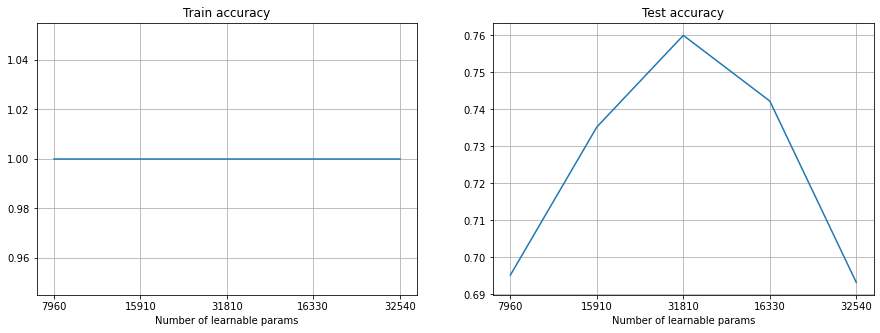

In [10]:
import time
from functools import reduce

# Function to compute the number of learnable parameters of a mlp given the size of its hidden layers
def param_count(hl_size):
    tot = 0
    input_size, output_size = X_train.shape[1], len(labels)
    tot += (input_size+1)*hl_size[0]
    for i in range(1,len(hl_size)):
        tot += (hl_size[i-1]+1)*hl_size[i]
    tot += (hl_size[-1]+1)*output_size
    return tot

hl_sizes = [(10,), (20,), (40,), (20,20,), (40,20,10)]
hl_labels = [param_count(t) for t in hl_sizes]

ti = time.time()
train_acc_list, test_acc_list = [], []
for hl_size in hl_sizes:
    print('Training MLP of size {} ...'.format(hl_size))
    mlp = MLPClassifier(hidden_layer_sizes = hl_size, max_iter=300,
                        alpha=1e-4, solver='sgd', tol=1e-4, random_state=ID, learning_rate_init=.1)
    mlp.fit(X_train, y_train)
    
    train_acc_list.append(mlp.score(X_train, y_train))
    test_acc_list.append(mlp.score(X_test, y_test))
    print('Done, training time: {:.2f} sec\n'.format(time.time()-ti))
    ti = time.time()

fig, ax = plt.subplots(1,2, figsize=(15,5))


ax[0].plot(train_acc_list)
ax[0].set_xlabel('Number of learnable params')
ax[0].set_title('Train accuracy')
ax[0].set_xticks(np.arange(0,len(hl_labels)))
ax[0].set_xticklabels(hl_labels)
ax[0].grid(True)

ax[1].plot(test_acc_list)
ax[1].set_xlabel('Number of learnable params')
ax[1].set_title('Test accuracy')
ax[1].set_xticks(np.arange(0,len(hl_labels)))
ax[1].set_xticklabels(hl_labels)
ax[1].grid(True)

## Question 2:

Comment about the training and test accuracies referring to the discussion on underfitting and overfitting we did in the course

## [ANSWER TO QUESTION 2]

With not enough neurons, NNs don't manage to make a really good fit. With too many neurons, NNs start to overfit since we are not using a lot of data. The performance peaks with a NN having a number of parameters adequate to the dimension of the training set: 40.\

### TO DO 4

Now try also to use different learning rates, while keeping the best NN architecture and batch size you have found above. Plot the learning curves (i.e., the variation of the loss over the steps, you can get it from the loss_curve_ object of sklearn) for the different values of the learning rate. Try to run each training for 100 iterations. 

Training MLP with lr: 0.0002


/home/lorenzo/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Done! Training, appending and plotting time: 12.40 sec

Training MLP with lr: 0.002
Done! Training, appending and plotting time: 5.63 sec

Training MLP with lr: 0.02
Done! Training, appending and plotting time: 1.56 sec

Training MLP with lr: 0.06
Done! Training, appending and plotting time: 0.89 sec

Training MLP with lr: 0.2
Done! Training, appending and plotting time: 0.49 sec

Training MLP with lr: 0.4
Done! Training, appending and plotting time: 0.38 sec



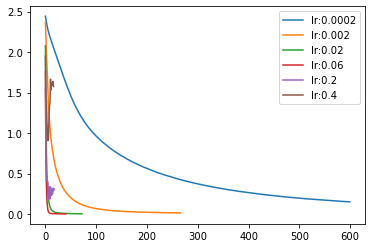

RESULTS FOR different Learning Rates:



,lr_param,train_scores,test_scores,times
0,0.0002,0.988333,0.75950,12.377472
1,0.0020,1.000000,0.75900,5.624496
2,0.0200,1.000000,0.76475,1.554637
3,0.0600,1.000000,0.77650,0.890965
4,0.2000,0.970000,0.70725,0.485910
5,0.4000,0.396667,0.33125,0.382557


None
Best parameters set found:


,lr_param,train_scores,test_scores,times
3,0.06,1.0,0.7765,0.890965


None
Score with best parameters:
0.7765


In [11]:
import matplotlib.pyplot as plt
import operator

lr_list = [0.0002, 0.002, 0.02, 0.06, 0.2, 0.4]
scores = {}

ti = time.time()
lr_train, lr_test, lr_times= [], [], []
for lr in lr_list:
    print(f"Training MLP with lr: {lr}")
    mlp = MLPClassifier(hidden_layer_sizes = (40,), batch_size=32, max_iter=600, alpha=1e-4, solver='sgd',       
                        tol=1e-4, random_state=ID, learning_rate_init=lr)
    mlp.fit(X_train, y_train)
    
    lr_train.append(mlp.score(X_train, y_train))
    lr_test.append(mlp.score(X_test, y_test))
    lr_times.append(time.time()-ti)
    plt.plot(mlp.loss_curve_, label = "lr:{}".format(lr))
    print('Done! Training, appending and plotting time: {:.2f} sec\n'.format(time.time()-ti))
    ti = time.time()

plt.legend(loc = 'best')
plt.show()
print ('RESULTS FOR different Learning Rates:\n')

lr_df = pd.DataFrame({'lr_param': lr_list, 'train_scores': lr_train, 'test_scores': lr_test,
                      'times': lr_times})
print(f"{display(HTML(lr_df.to_html()))}")
print("Best parameters set found:")
best_par=pd.DataFrame(lr_df.loc[lr_df['test_scores']==lr_df['test_scores'].max(),:])
print(f"{display(HTML(best_par.to_html()))}")

print("Score with best parameters:")
print(lr_df["test_scores"].max())


### QUESTION 3

Comment about the learning curves (i.e. the variation of the loss over the steps). How does the curve changes for different learning rates in terms of stability and speed of convergence ?

## [ANSWER TO QUESTION 3]

Using a high learning rate, makes the curve converge rapidly. The one with the smallest learning rate of 0.0002 does not even manage to converge in the 600 iterations. On the other hand, if the rate is too high, the learning becomes extremely imprecise and unstable, this is shown dramatically for 0.4. The best choice apparently is a learning rate of 0.06.

### TO DO 5

Now get training and test error for a NN with best parameters (architecture, batch size and learning rate) from above. Plot the learning curve also for this case (you can run the training for 500 iterations).


RESULTS FOR BEST NN

Best NN training error: 0.000000
Best NN test error: 0.223500


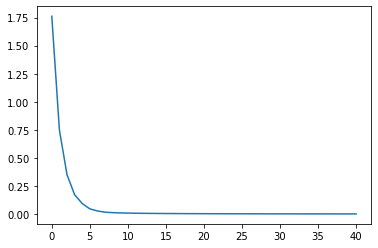

In [12]:
lr = 0.06
mlp = MLPClassifier(hidden_layer_sizes = (40,), batch_size=32, max_iter=500, alpha=1e-4,
                         solver='sgd', tol=1e-4, random_state=ID, learning_rate_init=lr)
mlp.fit(X_train, y_train)

best_train = 1. - mlp.score(X_train, y_train)
best_test  = 1. - mlp.score(X_test , y_test ) 
print ('\nRESULTS FOR BEST NN\n')

print ("Best NN training error: %f" % best_train)
print ("Best NN test error: %f" % best_test)

plt.plot(mlp.loss_curve_)
plt.show()

## More data 
Now let's do the same but using 4000 (or less if it takes too long on your machine) data points for training. Use the same NN architecture as before, but you can try more if you like and have a powerful computer!!

In [13]:
X = X[permutation]
y = y[permutation]

m_training = 4000

X_train, X_test = X[:m_training], X[m_training:]
y_train, y_test = y[:m_training], y[m_training:]

labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [376 429 417 387 382 401 398 411 397 402]


### TO DO 6

Now train the NNs with the added data points using the optimum parameters found above. Eventually, feel free to try different architectures if you like. We suggest that you use 'verbose=True' so have an idea of how long it takes to run 1 iteration (eventually reduce also the number of iterations to 50).


RESULTS FOR NN

NN training error: 0.000000
NN test error: 0.135000


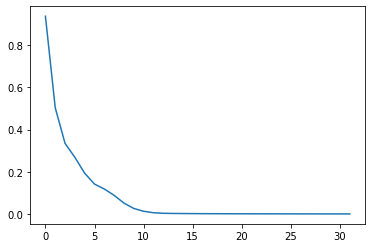

In [14]:

mlp_large = MLPClassifier(hidden_layer_sizes = (40,), batch_size=32, max_iter=600,
                         alpha=1e-4, solver='sgd', tol=1e-4, random_state=ID, learning_rate_init=0.06, verbose=False)
mlp_large.fit(X_train, y_train)

training_error = 1. - mlp_large.score(X_train, y_train)
test_error  = 1. - mlp_large.score(X_test , y_test ) 
print ('\nRESULTS FOR NN\n')

print ("NN training error: %f" % training_error)
print ("NN test error: %f" % test_error)

plt.plot(mlp_large.loss_curve_, label = 'loss curve')
plt.show()

## QUESTION 4
Compare the train and test error you got with a large number of samples with the best one you obtained with only 600 data points. Comment about the results you obtained.

#### [ANSWER TO QUESTION 4]

More training data allow more robust predictions. The training error is zero in both cases, while, as expected, the test error with more data is lower.

### TO DO 7

Plot an example that was missclassified by NN with m=600 training data points and it is now instead correctly classified by NN with m=4000 training data points.

INPUT:


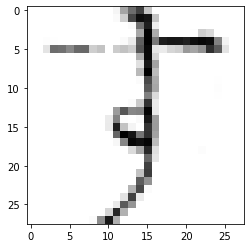

LABEL: 2
NN_label = 6
large_NN_label = 2
Real_label = 2


In [15]:
NN_prediction = mlp.predict(X_test)
large_NN_prediction = mlp_large.predict(X_test)

index = 0
for i in range(len(y_test)):
    if (NN_prediction[i]!=large_NN_prediction[i]):
        if (large_NN_prediction[i]==y_test[i]):
            index = i
            break

plot_input(X_test, y_test, index)
print(f"NN_label = {NN_prediction[i]}" )
print(f"large_NN_label = {large_NN_prediction[i]}" )
print(f"Real_label = {y_test[i]}")

### TO DO 8

Let's plot the weigths of the multi-layer perceptron classifier, for the best NN we get with 600 data points and with 4000 data points. The code is already provided, just fix variable names (e.g., replace mlp , mlp_large with your estimators) in order to have it working with your implementation



Weights with 600 data points:


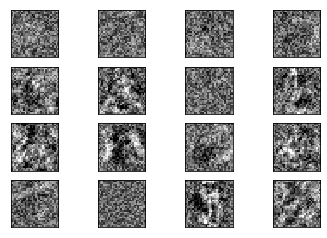

Weights with 4000 data points:


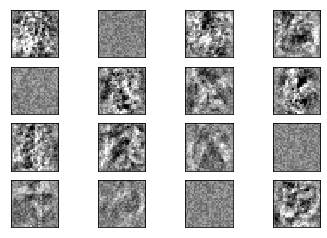

In [16]:
print("Weights with 600 data points:")

fig, axes = plt.subplots(4, 4)
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

print("Weights with 4000 data points:")

fig, axes = plt.subplots(4, 4)
vmin, vmax = mlp_large.coefs_[0].min(), mlp_large.coefs_[0].max()
for coef, ax in zip(mlp_large.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()


## QUESTION 5

Describe what do you observe by looking at the weights.

##### [ANSWER TO QUESTION 5]

The only difference I can see, is that with 4000 data the shapes are less blurred. Anyway I can't recognize anything in both of them

### TO DO 9

Take the best SVM model and its parameters, you found in the last notebook. Fit it on a few data points and compute its training and test scores. Then fit also a logistic regression model with C=1. 

In [17]:
m_training = 5000

X_train, X_test = X[:m_training], X[m_training:2*m_training]
y_train, y_test = y[:m_training], y[m_training:2*m_training]

best_SVM = SVC(kernel = 'rbf', C = 10, gamma = 0.01 )

best_SVM.fit(X_train, y_train)

SVM_training_error = 1.-best_SVM.score(X_train, y_train)
SVM_test_error = 1.-best_SVM.score(X_test, y_test)

print ('RESULTS FOR SVM')

print("Training error SVM: %f" % SVM_training_error)
print("Test error SVM: %f" % SVM_test_error)

RESULTS FOR SVM
Training error SVM: 0.000000
Test error SVM: 0.078200


In [18]:
from sklearn import linear_model

logreg = linear_model.LogisticRegression(C=1, max_iter=1000)

logreg.fit(X_train, y_train)

LR_training_error = 1-logreg.score(X_train, y_train)
LR_test_error = 1-logreg.score(X_test, y_test)
print ('\nRESULTS FOR LOGISTIC REGRESSION WITH REGULARIZATION')

print ("LR training error: %f" % LR_training_error)
print ("LR test error: %f" % LR_test_error)


RESULTS FOR LOGISTIC REGRESSION WITH REGULARIZATION
LR training error: 0.031800
LR test error: 0.240000


## QUESTION 6
Compare the results of Logistic Regression, SVM and NN. Which one achieve the best results? 

###### [ANSWER TO QUESTION 6]

The SVM achieves the best result by far. Logistic Regression is the worst, but has an error of the same order of the NN.
